# XGBoost Regressor


In [1]:
import sys
!{sys.executable} -m pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance

df = pd.read_csv("sales_data2.csv")

X = df.drop(columns=['Sales_Amount'])
y = np.log1p(df['Sales_Amount'])  # log transformacija targeta

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical)
], remainder='passthrough')

#XGBoost pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42))
])

model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # vraćanje na originalnu skalu
y_test_actual = np.expm1(y_test)

print("📊 Evaluacija XGBoost modela:")
print("MAE:", round(mean_absolute_error(y_test_actual, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_actual, y_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_actual, y_pred)), 2))
print("R² Score:", round(r2_score(y_test_actual, y_pred), 4))



📊 Evaluacija XGBoost modela:
MAE: 2624.8
MSE: 10516635.86
RMSE: 3242.94
R² Score: -0.3375


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

df = pd.read_csv("sales_data2.csv")

# ➕ 
df['Price_to_Cost_Ratio'] = df['Unit_Price'] / df['Unit_Cost']
df['Revenue_per_Unit'] = df['Sales_Amount'] / df['Quantity_Sold']
df['Has_Discount'] = (df['Discount'] > 0).astype(int)


y = np.log1p(df['Sales_Amount'])
X = df.drop(columns=['Sales_Amount'])

categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]



preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

X_prepared = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# conversion to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# training with early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtest, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_log = model.predict(dtest)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

print("📊 Results:")
print("MAE:", round(mean_absolute_error(y_test_original, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_original, y_pred), 2))
print("RMSE:", round(mean_squared_error(y_test_original, y_pred, squared=False), 2))
print("R² Score:", round(r2_score(y_test_original, y_pred), 4))


📊 Results:
MAE: 566.94
MSE: 818520.26
RMSE: 904.72
R² Score: 0.8959


FEATURE IMPORTANCE 
~ analyzing which factors affect the model the most

<Figure size 1200x800 with 0 Axes>

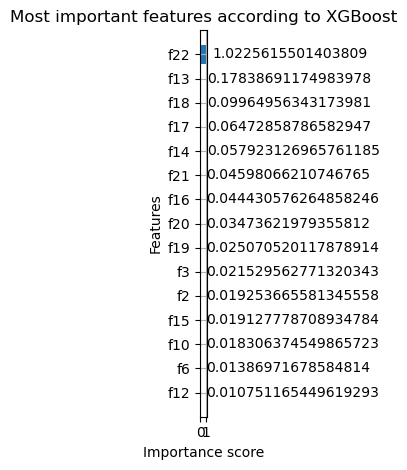

In [4]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=15, importance_type='gain', height=0.8)
plt.title("Most important features according to XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()


Better code below:

📊 Results:
MAE: 566.94
MSE: 818520.26
RMSE: 904.72
R² Score: 0.8959


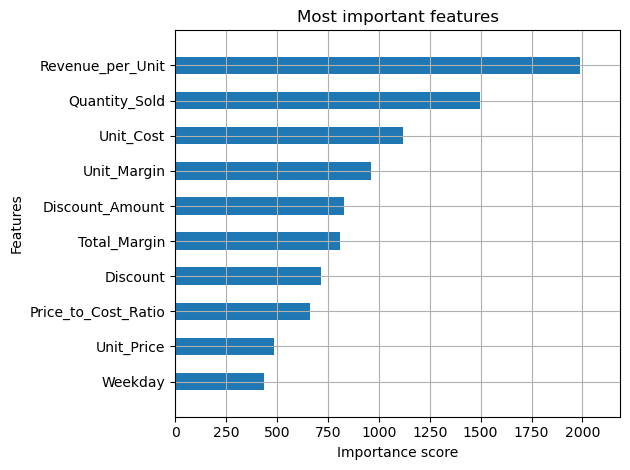

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

df = pd.read_csv("sales_data2.csv")

df['Price_to_Cost_Ratio'] = df['Unit_Price'] / df['Unit_Cost']
df['Revenue_per_Unit'] = df['Sales_Amount'] / df['Quantity_Sold']
df['Has_Discount'] = (df['Discount'] > 0).astype(int)

y = np.log1p(df['Sales_Amount'])  # log-transformacija targeta
X = df.drop(columns=['Sales_Amount'])

categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

X_prepared = preprocessor.fit_transform(X)

ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical)
feature_names = list(ohe_feature_names) + numerical

X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtest, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_log = model.predict(dtest)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

print("📊 Results:")
print("MAE:", round(mean_absolute_error(y_test_original, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_original, y_pred), 2))
print("RMSE:", round(mean_squared_error(y_test_original, y_pred, squared=False), 2))
print("R² Score:", round(r2_score(y_test_original, y_pred), 4))

# feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10, height=0.5, show_values=False)
plt.title("Most important features")
plt.tight_layout()
plt.show()


SHAP ANALYSIS

In [6]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


📊 Rezultati:
MAE: 566.94
MSE: 818520.26
RMSE: 904.72
R² Score: 0.8959


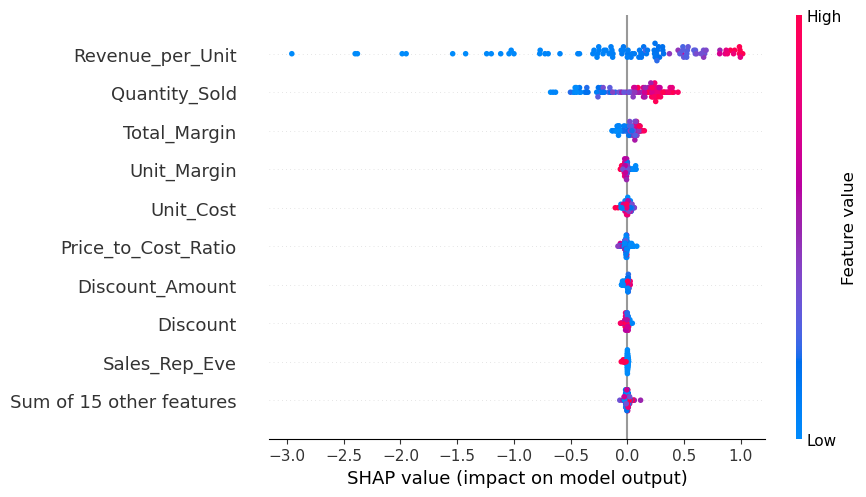

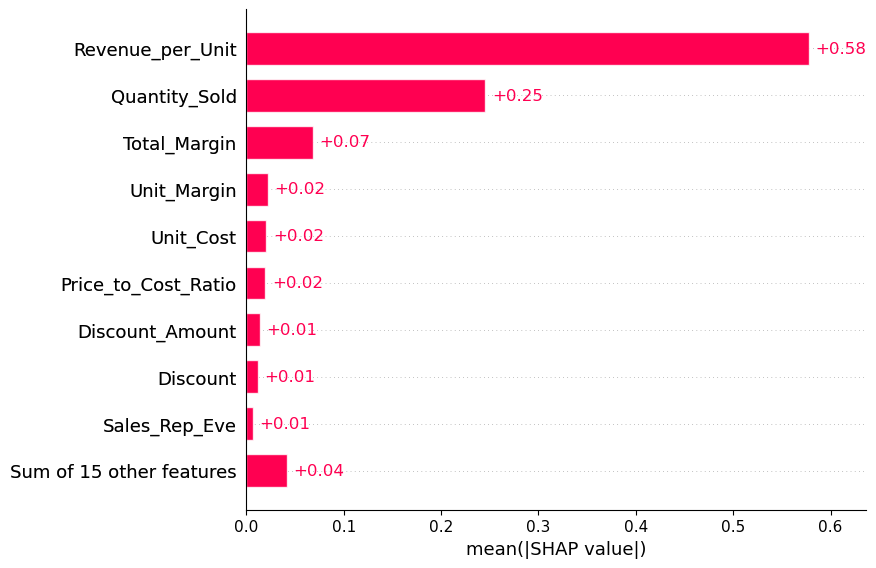

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

df = pd.read_csv("sales_data2.csv")

df['Price_to_Cost_Ratio'] = df['Unit_Price'] / df['Unit_Cost']
df['Revenue_per_Unit'] = df['Sales_Amount'] / df['Quantity_Sold']
df['Has_Discount'] = (df['Discount'] > 0).astype(int)

y = np.log1p(df['Sales_Amount'])
X = df.drop(columns=['Sales_Amount'])

categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

X_prepared = preprocessor.fit_transform(X)

ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical)

all_feature_names = list(ohe_feature_names) + numerical


X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtest, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_log = model.predict(dtest)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

print("📊 Rezultati:")
print("MAE:", round(mean_absolute_error(y_test_original, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_original, y_pred), 2))
print("RMSE:", round(mean_squared_error(y_test_original, y_pred, squared=False), 2))
print("R² Score:", round(r2_score(y_test_original, y_pred), 4))

# ------------------------------------------
# 🧠 SHAP analysis
# ------------------------------------------

explainer = shap.Explainer(model, feature_names=all_feature_names)
shap_values = explainer(dtest)

shap.initjs()

# Beeswarm
shap.plots.beeswarm(shap_values)

# 📊 Bar plot 
shap.plots.bar(shap_values)


PDP

MAE: 634.48
MSE: 930498.37
RMSE: 964.62
R² Score: 0.8817


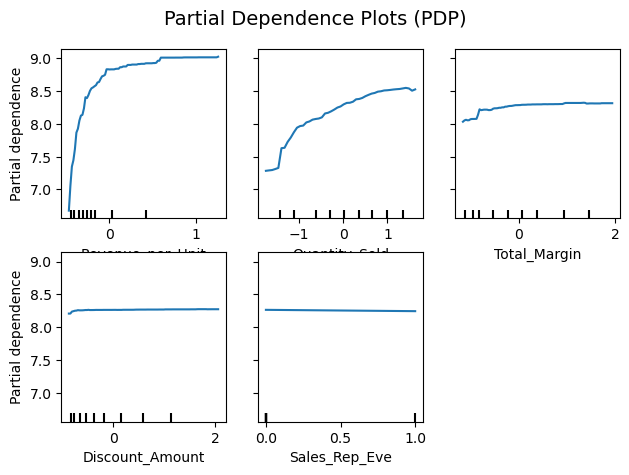

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay

df = pd.read_csv("sales_data2.csv")

df['Price_to_Cost_Ratio'] = df['Unit_Price'] / df['Unit_Cost']
df['Revenue_per_Unit'] = df['Sales_Amount'] / df['Quantity_Sold']
df['Has_Discount'] = (df['Discount'] > 0).astype(int)

y = np.log1p(df['Sales_Amount'])  # log-transformacija
X = df.drop(columns=['Sales_Amount'])

categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

X_prepared = preprocessor.fit_transform(X)

ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical)
numeric_feature_names = numerical
feature_names = np.concatenate([ohe_feature_names, numeric_feature_names])

X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

print("MAE:", round(mean_absolute_error(y_test_original, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_original, y_pred), 2))
print("RMSE:", round(mean_squared_error(y_test_original, y_pred, squared=False), 2))
print("R² Score:", round(r2_score(y_test_original, y_pred), 4))

# 📌 feature indexes for PDP
features_to_plot = [
    feature_names.tolist().index("Revenue_per_Unit"),
    feature_names.tolist().index("Quantity_Sold"),
    feature_names.tolist().index("Total_Margin"),
    feature_names.tolist().index("Discount_Amount"),
    feature_names.tolist().index("Sales_Rep_Eve")
]

# 🖼️ PDP graph
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=features_to_plot,
    feature_names=feature_names,
    kind="average"
)
plt.suptitle("Partial Dependence Plots (PDP)", fontsize=14)
plt.tight_layout()
plt.show()